# Intelligent Architectures (5LIL0) Assignment 1 (version 0.3)

#### Authors: Marzieh Hashemipour-Nazari, Alexios Balatsoukas-Stimming, License: [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)

## Part A: Multi-layer perceptron for handwritten digit recognition from scratch

In the first part of lab 1, we want to generate a multilayer perceptron for handwritten digit classification from scratch: Using only  `NumPy` and `matplotlib` libraries.

## Import
Let us import these two libraries. We also set the number of threads for various libraries to one for reproducibility.

In [50]:
import os 
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## 1. Data preparation 
Our data is from the **MNIST** dataset of 28x28 pixel images of handwritten digits from 0-9. We first need to unzip the data.

In [ ]:
#unzip data
# !cd data && tar xzf mnist_data.tar.gz && cd ..

### 1.1 Load the data
After unzipping, we have two comma-separated values (csv) files: **mnist_train.csv** and **mnist_test.csv** for training and testing, respectively. First, we need to load our data. Let's do it by defining a new function called `LoadData`. 

We have 60000 samples in the train set and 10000 samples in the test set. Each sample, which is a 28 x 28 image, is unrolled into a 1-dimensional vector of length 28 x 28 = 784. The `LoadData()` function loads the data into two separate arrays $X$ and $Y$. We can determine the number of samples we want for training and testing our network with the `samples` input value. The upper bound for `samples` for the training and test data is 60000 and 10000, respectively.

In [51]:
def LoadData(DirName,samples = 500):
    """
    :return: image label and data.
    """
    # They put the label in the first col(1*785) for one image.
    data = list();
    count = 0;
    with open(DirName) as f:
        for line in f:
            if count<samples:
                new_line = np.array(line.split(','))
                new_line = new_line.astype(np.float32)
                data.append(new_line)
                count += 1
    data = np.asarray(data)
    
    return data[:,0],data[:,1:]

NoTrain = 60000
NoTest = 10000
# No shuffle operation
Y_train,x_train = LoadData("./data/mnist_train.csv", NoTrain)
Y_test,x_test = LoadData("./data/mnist_test.csv", NoTest)

print(f"Test set size: {x_test.shape[0]} x {x_test.shape[1]}")
print(f"Train set size: {x_train.shape[0]} x {x_train.shape[1]}")

Test set size: 10000 x 784
Train set size: 60000 x 784


### 1.2 MNIST visualization
Here, we just want to show how the dataset looks like with a sample example defined by the `sample` variable. To do this, we need to resize the flattened length-784 representation into a 28 x 28 matrix for compatibility with the `imshow()` function from `matplotlib`.

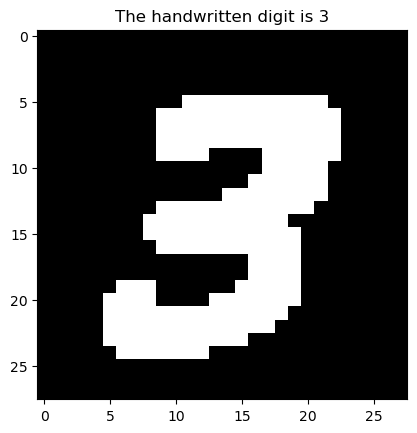

In [52]:
sample = 7;  # index of the image we want to show

plt.title(f'The handwritten digit is {Y_train[sample]:.0f}')

# Reshape the array into 28 x 28 array (2-dimensional array)
pixels = x_train[sample,:].reshape((28, 28))
plt.imshow(pixels, cmap='gray',vmin=0,vmax=1.0)
plt.show()

### 1.3 Rescaling and encoding the data
#### Rescaling feature values (input data) 
The input data in the $X$ array takes on values from 0 to 255. Rescaling the data to a smaller range can help with training convergence. One common way is the standardization method where the data is rescaled so that its mean is 0 and its standard deviation is 1. This is done using the following formula:
$$
X^{\prime}=\frac{X-\mu}{\sigma},
$$
where $\mu$ is the mean of the training data features and $\sigma$ is the standard deviation of the training data features.

In [53]:
# standardize training and test data
# (60000, 784)
# mu_train = np.mean(x_train)
# sigma_train = np.sqrt(np.sum((x_train - mu_train) ** 2) / (x_train.shape[0] - 1))

# mu_test = np.mean(x_test, axis=0)
# sigma_test = np.std(x_test, axis=0)
# sigma_test[sigma_test == 0] = 1

# x_train_st = (x_train - mu_train) / sigma_train
x_train_st = (x_train - np.mean(x_train)) / np.std(x_train)
x_test_st = (x_test - np.mean(x_test)) / np.std(x_train)


print(f"Your training data mean is {np.mean(x_train_st):.3f} and your standard deviation is {np.std(x_train_st):.3f}")
print(f"Correct training data mean is {-0.000:.3f} and correct standard deviation is {1.000:.3f}")
print(f"Your test data mean is {np.mean(x_test_st):.3f} and your standard deviation is {np.std(x_test_st):.3f}")
print(f"Correct test data mean is {0.006:.3f} and correct standard deviation is {1.008:.3f}")

Your training data mean is -0.000 and your standard deviation is 1.000
Correct training data mean is -0.000 and correct standard deviation is 1.000
Your test data mean is -0.000 and your standard deviation is 1.008
Correct test data mean is 0.006 and correct standard deviation is 1.008


#### Encoding the output 
In addition, for categorical data (where image is labeled between 0-9), we need the one-hot encoded representation of our data, meaning each label is converted into a binary vector (e.g. the label 9 would be the vector [0,0,0,0,0,0,0,0,0,1]).

In [54]:
# One-hot encoding train and test sets labels 
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size),Y_train.astype(int)] = 1.0;

y_test  = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size),Y_test.astype(int)] = 1.0;

print(f"Your decimal label is {Y_train[0]:.0f} and your one-hot encoded label is {y_train[0,:]}")
print(f"Correct decimal label is 5 and correct one-hot encoded label is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]")

Your decimal label is 5 and your one-hot encoded label is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Correct decimal label is 5 and correct one-hot encoded label is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 2. Neural networks (NN)
Neural networks (NN) are a collection of connected layers consisting of nodes called artificial neurons. Each connection transmits a "signal" to other neurons. An artificial neuron that receives a signal then processes it and can signal neurons connected to it.
The "signal" at a connection is a real number, and the output of each neuron is computed by an activation function applied to a weighted sum of its inputs. Signals traverse from the first layer (the input layer), to the last layer (the output layer). 
The neurons in the hidden layers, which are located between the input and output layers, receive input from the neurons in the input layer or from neurons in earlier hidden layers.

### 2.1 Multi-layer perceptrons (MLP)
The most well-known NN model is the multi-layer perceptron (MLP), which is a feed-forward fully-connected network. 
An MLP model has fully-connected layers such that every input neuron is connected to every neuron in the next layer, where information only moves forward (no feedback). Therefore, neurons move the input value of one layer to the next layer. Mathematically, the MLP model defines a parameterized function in which each layer computes a weighted linear combination, $h =XW+b$ of the layer input denoted by the vector $X$, followed by an activation function $\sigma(h)$. MLP configuration can be repeatedly chained to build a deep neural network (DNN).
The following figure shows the structure of a simple MLP with one hidden layer.

<img src="mlp.jpg" width="600">

Image credit: [https://github.com/PetarV-/TikZ/tree/master/Multilayer%20perceptron](https://github.com/PetarV-/TikZ/tree/master/Multilayer%20perceptron)

$W_i$ denotes the weights connecting the $(i − 1)$-th layer to the $i$-th layer and determines the strength and sign of the connection between these two layers. In addition to the weights, there is usually a bias term (denoted by $b$) to adjust the offset. The output of the $i$-th layer, denoted by $O^i$, is determined as:
$$
O^{(i)} = \sigma\left(O^{(i-1)}W^{(i)}+b^{(i)}\right),
$$
where $\sigma(x)$ is the activation function for the corresponding layer. The output of the input layer $O^{(0)}$ is the input vector $X$. In our example, the output layer has 10 dimensions for representing the one-hot encoded binary vector of output labels.

### 2.2 Activation functions
The activation function depicted as $\sigma(\cdot)$ is an element-wise non-linear function. There are multiple activation functions available for different NN models. In this lab, we use two of them called **sigmoid** and **ReLU** for the hidden layer and output layer, respectively.

__sigmoid:__$$\sigma(x)=\frac{1}{1+e^{-x}}$$
__ReLU:__ $$ \sigma(x)= \begin{cases}0, &  x<0, \\ x, &  x\geq 0.\end{cases}$$

### 2.3 Forward pass

The process of generating an output from an input is called a forward pass. For an MLP, the forward pass is basically a series of matrix multiplications followed by activation function applications. We want to define an MLP with one hidden layer for the digit recognition problem with MNIST dataset. Below is the figure for the desired MLP model:

<img src="nn_mnist.jpg" width="600">

__Note:__ The superscript $i={0,1,2}$ in the figure indicates the associated layer number. In addition, for the sake of simplicity, the required calculations and output only for the first neuron in each layer are specified in the figure. The remaining neurons in each layer have the same structure as the first one.

There are 128 neurons for the hidden layer. As said before, the activation function for the hidden layer is different from the output layer. 
As shown in the figure, the output of each neuron in the hidden layer will be calculated as follows:
$$
O^{(1)}_{j}=\text{ReLU}\left(\sum_{i=0}^{783} x_i \times w^{(0)}_{i, j}\right) \; \text{ for } \; j={1,2,...,128}
$$
(__note:__ There is no bias term in this example). 
As the figure shows, the weights $w^{(0)}_{i,j}$ need to be compacted into a matrix $W^{(0)}\in \mathbb{R}^{784\times128}$, allowing for all the neurons in the hidden layer to be efficiently calculated using matrix multiplication. As a different weight matrix is needed to transform the hidden layer to the output layer, $W^{(0)}$ is the matrix that transforms the inputs to the hidden layer:
$$
O^{(1)} = \text{ReLU}\left(h^{(0)}\right), \text{ where } h^{(0)}=XW^{(0)}  
$$
Similarly, $W^{(1)}$ transforms the hidden layer to the output layer as follows:
$$
O^{(2)}_{j}=\text{sigmoid}\left(O^{(1)}W^{(1)}\right), O^{(1)} \in \mathbb{R}^{1\times 128}, W^{(1)} \in \mathbb{R}^{128\times 10} 
.$$

The last step of the classification task is producing a prediction from $O^{(2)}_j, j=\{0,1,...,M-1\}$ in the output layer, where $M$ is the number of labels ($M=10$ in the MNIST dataset). Typically, for the multi-label classification, the **softmax** function is used to convert the output of the $M$ neurons in the output layer into probabilities as follows:
$$
\text{softmax}(z_j) =\frac{e^{z_j}}{\sum^{M-1}_{i=0}e^{z_i}},
$$
The interesting property of this function is that the sum of all the outputs of softmax, is always equal to 1:
$$
\sum^{M-1}_{i=0}\text{softmax}({z_i}) = 1
$$
Therefore, applying softmax to the output layer of our example effectively converts the output of neurons into probabilities for each label in the vector $\hat{y}$ as follows:
$$
\hat{y}_j = \text{softmax}\left({O^{(2)}_j}\right), \; j\in \{0,1,...,M-1\}.
$$

Now, we have revisited the math behind the forward pass for an MLP model. So, let's start implementing everything we have looked at in the python code:

### 3. MLP Implementation

#### 3.1 Input initialization
As we want to write efficient and fast code, we use matrix (NumPy multidimensional arrays) operations whenever possible. NumPy will automatically use parallelism whenever possible, which will help to substantially accelerate our code (this is also sometimes called vectorizing your code).

The input vector $X$, weight matrices $W^{(0)}$ and $W^{(1)}$, and activation functions are all we need to define the forward pass.

In [55]:
X = x_train_st 
Y = y_train 

N_l = 128  # number of neurons in hidden layer

layers = np.array([X.shape[1]]+[N_l]+[Y.shape[1]]) # layers = [784 128 10]

print('Your', '\033[1m' + 'layers' + '\033[0m','array is:', layers)
print('Correct ', '\033[1m' + 'layers' + '\033[0m','array is: [784 128  10]')

Your layers array is: [784 128  10]
Correct  layers array is: [784 128  10]


#### 3.2 Weight initialization
In order to perform a forward pass, our input vector $X$ is consecutively multiplied by weight matrices and then passed into the corresponding activation functions.
The values of the weight matrices will ultimately be learned through backpropagation, but each weight matrix must first be initialized to random values.
There are several different methods for doing this initialization. Here, we use a simple approach to initiate the values from a uniform distribution on the range [-1,1].

In [56]:
# Weights for feedforward
np.random.seed(seed=0)

def init_weights(layers):
    weights = list()
    # for hidden layer
    # weights_l1 = ...  # weights for hidden layer
    weights_l1 = np.random.uniform(-1, 1, (784, 128))
    weights.append(weights_l1)
    #for output layer
    weights_l2 = np.random.uniform(-1, 1, (128, 10)) # weights for output layer
    weights.append(weights_l2)
    
    weights = np.asarray(weights,dtype=object)
    return weights

weights = init_weights(layers)

print(f"Dimension of your weight matrix for the hidden layer is {weights[0].shape[0]} x {weights[0].shape[1]} and for the output layer is {weights[1].shape[0]} x {weights[1].shape[1]}")
print("Dimension of the correct weight matrix for the hidden layer is 784 x 128 and for the output layer is 128 x 10")

print(f"Your initialized weight connecting the first neuron in the hidden layer to the first neuron in the output layer is {(weights[1][0][0]):.6f}")
print("Correct initialized weight connecting the first neuron in the hidden layer to the first neuron in the output layer is 0.705750")


Dimension of your weight matrix for the hidden layer is 784 x 128 and for the output layer is 128 x 10
Dimension of the correct weight matrix for the hidden layer is 784 x 128 and for the output layer is 128 x 10
Your initialized weight connecting the first neuron in the hidden layer to the first neuron in the output layer is 0.705750
Correct initialized weight connecting the first neuron in the hidden layer to the first neuron in the output layer is 0.705750


#### 3.3 Activation functions

Here, we will define the activation functions required by our network, namely the `ReLU()`, `sigmoid()`, and `softmax()` functions.

In [57]:
def ReLU(x):
    """
    Input Parameters:
    x : input: float of array
    
    Returns:
    ReLU(x) : float or array
    """
    y = np.maximum(0, x)
    return y

def sigmoid(x):
    """
    Input Parameters:
    x : input: float of array
    
    Returns:
    sigmoid(x) : float or array
    """
    x = np.clip(x, -50, 50)
    y = 1 / (1 + np.exp(-x))
    return y

def softmax(x):  
    """
    Input Parameters:
    x : input: array(n x p) : n samples by p dimensions : p=10 for MNIST (because we have 0-9 digits)
    
    Returns:
    softmax(x) : float or array
    """
    y = np.zeros_like(x)
    for i in range(np.shape(x)[0]):
        y[i] = np.exp(x[i]) / np.sum(np.exp(x[i]))
    return y

print(f"Your outputs: ReLU(-0.1) = {ReLU(-0.1):.3f}, ReLU(0.1) = {ReLU(0.1):.3f}, sigmoid(-0.1) = {sigmoid(-0.1):.3f}, sigmoid(0.1) = {sigmoid(0.1):.3f}, softmax([0.1 0.2] =", softmax([[0.1, 0.2]]))
print("Correct outputs: ReLU(-0.1) = 0.000, ReLU(0.1) = 0.100, sigmoid(-0.1) = 0.475, sigmoid(0.1) = 0.525, softmax([0.1 0.2] = [[0.47502081 0.52497919]]) ")

Your outputs: ReLU(-0.1) = 0.000, ReLU(0.1) = 0.100, sigmoid(-0.1) = 0.475, sigmoid(0.1) = 0.525, softmax([0.1 0.2] = [[0.47502081 0.52497919]]
Correct outputs: ReLU(-0.1) = 0.000, ReLU(0.1) = 0.100, sigmoid(-0.1) = 0.475, sigmoid(0.1) = 0.525, softmax([0.1 0.2] = [[0.47502081 0.52497919]]) 


### 3.4 Layer initialization
The values for hidden and output layers will be stored in multi-dimensional matrices. 

In [58]:
# Initialization of the layer outputs
n_samples = X.shape[0]

def init_layer(layers,n_samples):
    h = [np.empty((n_samples,layers[1])),np.empty((n_samples,layers[2]))] 
    o = [np.empty((n_samples,layers[0])),np.empty((n_samples,layers[1])),np.empty((n_samples,layers[2]))] 
    return h,o

h,o = init_layer(layers,n_samples)

print(f"h size (hidden layer): {h[0].shape[0]} x {h[0].shape[1]}")
print(f"h size (output layer): {h[1].shape[0]} x {h[1].shape[1]}")

h size (hidden layer): 60000 x 128
h size (output layer): 60000 x 10


### 3.5 Forward pass
For simplicity, we ask you to implement a hard-coded version of the specific MLP, i.e., your code does not need to be generic for any number of layers, neurons, etc. Therefore, you only need to implement the matrix multiplication and apply the requested activation functions for each layer.

In [59]:
def feedforward(data,weights,o,h):
    
    # Input layer
    o[0] = data
    
    # Hidden layer --> ReLU activation
    h[0] = np.dot(o[0], weights[0])
    o[1] = ReLU(h[0])

    # Output Layer --> sigmoid + softmax activations
    h[1] = np.dot(o[1], weights[1])
    o[2] = sigmoid(h[1])
    Y_hat = softmax(o[2])
    
    return Y_hat

Y_hat = feedforward(X,weights,o,h)

with np.printoptions(precision=4, suppress=True):
    print('Your predicted output for the first training sample is:', Y_hat[0])
print('Correct predicted output for the first training sample is: [0.0593 0.1611 0.0593 0.1611 0.0593 0.0593 0.1611 0.0593 0.1611 0.0593]')


Your predicted output for the first training sample is: [0.0593 0.1611 0.0593 0.1611 0.0593 0.0593 0.1611 0.0593 0.1611 0.0593]
Correct predicted output for the first training sample is: [0.0593 0.1611 0.0593 0.1611 0.0593 0.0593 0.1611 0.0593 0.1611 0.0593]


## 4. Loss/Cost function
A loss function, which quantifies how "wrong" the neural network's output $\hat{\mathbf{y}}$ is compared to the expected output $\mathbf{y}$, is used to assess the neural network's performance.
### 4.1 Cross-entropy loss function
The loss function should reflect the objective of the defined neural network. For example, in our design, we want to classify the handwritten digits from 0-9. The cross-entropy loss, also known as the negative log-likelihood, is most commonly used for classification problems. Below is the mathematical representation of this function:
$$
\text{L}(\mathbf{y},\hat{\mathbf{y}}) = -\sum_{k=0}^{M-1}{y_k \log(\hat{y}_k)},
$$
where $M$ is the number of distinct labels. The following equation is used to define the cost function over $N$ input samples:
$$
\text{C} = \sum_{j=1}^{N}{\text{L}(\mathbf{y}^{(i)},\hat{\mathbf{y}}^{(i)})}.
$$
The following function calculates the overall cost function $C$.

In [60]:
#cross entropy loss  
def cross_entropy(y_pred,y):
    """
    Input Parameters:
    y_pred, y : array of float
    
    Returns:
    c : float
    """
    
    # Compute loss
    loss = -(y * np.log(y_pred))
    c = np.sum(loss)
    return c

loss = cross_entropy(Y_hat,Y)
print(f"Your loss with randomly initialized weights is {loss:.3f}")
print(f"Correct loss with randomly initialized weights is 143488.412")

Your loss with randomly initialized weights is 143488.412
Correct loss with randomly initialized weights is 143488.412


### 4.2 Accuracy 
The input is normally classified according the output label with the highest likelihood. 
$$
\text{prediction}(x) = \text{argmax}(\hat{\mathbf{y}}) 
$$
Therefore, to evaluate the classification accuracy of our model, we must identify the output label with the highest probability, assign "1" to that label, and set the remaining labels to "0". We can then calculate the accuracy of our classifier by comparing the predicted with the actual label in the dataset. The two functions below implement this functionality.

In [61]:
def labeling(x):  
    # Set the label with the max probability to '1' and the rest to 0 
    label = np.zeros((x.shape[0],Y.shape[1]))
    label[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
    return label

def accuracy(y_pred,y):  
    # Calculate the accuracy along the rows, averaging the results over the number of samples.
    correct_num = 0
    for i in range(np.shape(y_pred)[0]):
        for j in range(len(y_pred[i])):
            if y_pred[i][j] == 1:
                pred_label = j
            if y[i][j] == 1:
                true_label = j
        if pred_label == true_label:
            correct_num += 1
    acc = correct_num / np.shape(y_pred)[0]
    return acc

acc = accuracy(labeling(Y_hat),Y)
print(f"Your accuracy with randomly initialized weights is {acc:.4f}")
print(f"Correct accuracy with randomly initialized weights is 0.1163")

Your accuracy with randomly initialized weights is 0.1163
Correct accuracy with randomly initialized weights is 0.1163


## 5. Training
The process of iteratively updating the weights of the network to improve performance is called training.

### 5.1 Gradient descent
As mentioned earlier, the performance of the neural network is evaluated using the loss function $C$.
Therefore, we aim to minimize the loss function by learning the weights of the neural network. This can be done with __gradient descent (GD)__ algorithm defining the update rule as follows:
$$
W^{(l)}_t = W^{(l)}_{t-1}-\eta\frac{\partial C}{\partial W^{(l)}_{t-1}},
$$
where $t$ is the iteration number, $\eta$ is the learning rate to tune the steps in the GD algorithm, and $\frac{\partial C}{\partial W^{(l)}_{t}}$ is the partial derivative of the loss function with respect to the weight matrix connecting the neurons in layer $(l-1)$ to the neurons in layer $l$. The algorithm takes steps towards the minimum value of a cost function $C$. The size of each step is proportional to the magnitude of the gradient, which is the partial derivative of the cost function with respect to each parameter. 

Since the derivative of a sum equals a sum of derivatives (i.e., differentiation is a linear operation), we can rewrite the update rule as follows:
$$
W^{(l)}_{t} = W^{(l)}_{t-1}-\eta\sum_{i=1}^{N}\frac{\partial L_i}{\partial W^{(l)}_{t-1}},
$$
where $L_i=L\left(\mathbf{y}^{(i)},\hat{\mathbf{y}}^{(i)}\right)$ is the cross entropy loss for the $i$-th sample in our training set. Once we compute the derivative $\frac{\partial L_i}{\partial W^{(l)}_{t-1}}$ for each training set sample, we can add all individual derivative terms to compute $\frac{\partial C}{\partial W^{(l)}_{t-1}}$.

### 5.2 Backpropagation
To perform GD for our example, we need to calculate the gradient $\frac{\partial C}{\partial W^{(1)}}$ and $\frac{\partial C}{\partial W^{(0)}}$ for the weight matrices in the output and hidden layers, respectively (note that we drop the subscripts $t$ and $i$ to simplify the notation). Backpropagation is an algorithm to compute these gradients efficiently. To calculate $\frac{\partial L}{\partial W^{(1)} }$, we use the chain rule:
$$
\frac{\partial L}{\partial W^{(1)}} = \frac{\partial L}{\partial h^{(1)}}\times \frac{\partial h^{(1)}}{\partial W^{(1)}},
$$
where $\frac{\partial h^{(1)}}{\partial W^{(1)}} = O^{(1)}$ as $h^{(1)}=O^{(1)}W^{(1)}$.
For  $\frac{\partial L}{\partial h^{(1)}}$, let's apply the chain rule again and define $\delta_1$ which we will use later:
$$
\delta_1 \triangleq \frac{\partial L}{\partial h^{(1)}} =  \frac{\partial L}{\partial O^{(2)}} \times  \frac{\partial O^{(2)}}{\partial h^{(1)}}.
$$
The term $\frac{\partial L}{\partial O^{(2)}}$ is the partial derivative of the cross entropy loss function with respect to the input of softmax function, and it is equal to $\hat{y}-y$ (see the detailed explanation [here](https://www.mldawn.com/back-propagation-with-cross-entropy-and-softmax/)). Since $O^{(2)} = \text{sigmoid}\left(h^{(1)}\right)$, we have $\frac{\partial O^{(2)}}{\partial h^{(1)}} = \text{sigmoid}\left(h^{(1)}\right)\left(1-\text{sigmoid}\left(h^{(1)}\right)\right)$, which is the derivative of the sigmoid activation function with respect to its input (see the detailed explanation [here](https://scribe.esmailelbob.xyz/derivative-of-the-sigmoid-function-536880cf918e)). Therefore, putting everything together, we have that:
$$
\frac{\partial L}{\partial W^{(1)}} = {\left(O^{(1)} \right)}^{T} \left(\hat{y}-y\right)\text{sigmoid}\left(h^{(1)}\right)\left(1-\text{sigmoid}\left(h^{(1)}\right)\right)
$$
__Note:__ for the derivative with respect to a matrix, we need to be careful about the matrix dimension. For details, we recommend [this video](https://www.youtube.com/watch?v=GlcnxUlrtek&list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU&index=5).

Next, we need to calculate $\frac{\partial L}{\partial W^{(0)} }$ for the hidden layer in a similar way. Again, we apply the chain rule:
$$
\frac{\partial L}{\partial W^{(0)}} = \frac{\partial L}{\partial h^{(0)}}\times \frac{\partial h^{(0)}}{\partial W^{(0)}}= {\left(O^{(0)}\right)}^{T} \times \delta_0\\
\delta_0 \triangleq \frac{\partial L}{\partial O^{(1)}} \times \frac{\partial O^{(1)}}{\partial h^{(0)}} = \frac{\partial L}{\partial O^{(1)}} \times \text{ReLU}'(h^{(0)}),
$$
where $\text{ReLU}'(h^{(0)}) = \begin{cases} 0, & h^{(0)} \leq 0, \\ 1, & h^{(0)} > 1,\end{cases}$ is the derivative of the ReLU activation function with respect to its input. Continuing the chain rule and using $\delta_2$ defined previously, we have:
$$
\frac{\partial L}{\partial O^{(1)}} = \frac{\partial L}{\partial h^{(1)}} \times \frac{\partial h^{(1)}}{\partial O^{(1)}} = \delta_1 \times \left({W^{(1)}}\right)^{T}.
$$
So, finally we have:
$$
\frac{\partial L}{\partial W^{(0)}} = {\left(O^{(0)}\right)}^{T} \times \delta_1 \times {\left(W^{(1)}\right)}^{T} \times \text{ReLU}'(h^{(0)}) 
$$

### 5.3 Backpropagation implementation
Now, we want to implement backpropagation for one sample from the dataset. First, we need to implement the derivatives of the **sigmoid** and **ReLU** activation functions:

In [62]:
def sigmoid_prime(x):
    # Compute the derivative of sigmoid where h=sigmoid(x)
    derivative = sigmoid(x) * (1 - sigmoid(x))
    return derivative

def ReLU_prime(x):
    # Derivative of ReLU function
    # return derivative
    return np.where(x > 0, 1.0, 0.0)

print(f"Your sigmoid derivative at x = 0.1 is {sigmoid_prime(0.1):.3f}")
print(f"Correct sigmoid derivative at x = 0.1 is 0.249")
print(f"Your ReLU derivative at x = 0.1 is {ReLU_prime(0.1):.3f} and at at x = -0.1 is {ReLU_prime(-0.1):.3f}")
print(f"Correct ReLU derivative at x = 0.1 is 1.000 and at at x = -0.1 is 0.000")

Your sigmoid derivative at x = 0.1 is 0.249
Correct sigmoid derivative at x = 0.1 is 0.249
Your ReLU derivative at x = 0.1 is 1.000 and at at x = -0.1 is 0.000
Correct ReLU derivative at x = 0.1 is 1.000 and at at x = -0.1 is 0.000


Then, we calculate $\delta_1$ and $\frac{\partial L}{\partial W^{(1)}}$ for the output layer and $\delta_0$ and $\frac{\partial L}{\partial W^{(0)}}$ for the hidden layer, only for the first sample of our training set for the time being.

In [63]:
# Calculate d(L,w1)
delta_1 = np.multiply((Y_hat - Y), sigmoid_prime(h[1]))
d_l_w1 = np.dot(o[1].T, delta_1)

# Calculate d(L,w0)
delta_0 = np.dot(delta_1, weights[1].T) * ReLU_prime(h[0])
d_l_w0 = np.dot(o[0].T, delta_0)

print(f"Your derivative of the cost function with respect to W^(1) connecting the first neuron of the input layer to the first neuron of the hidden layer is: {(d_l_w1[0][0]):.10f}")
print('Correct derivative of the cost function with respect to W^(1) connecting the first neuron of the input layer to the first neuron of the hidden layer is: 0.0006078749')
print(f"Your derivative of the cost function with respect to W^(0) connecting the first neuron of the input layer to the first neuron of the hidden layer is: {(d_l_w0[0][0]):.10f}")
print('Correct derivative of the cost function with respect to W^(0) connecting the first neuron of the input layer to the first neuron of the hidden layer is: -0.0000148791')

Your derivative of the cost function with respect to W^(1) connecting the first neuron of the input layer to the first neuron of the hidden layer is: -200.6150280914
Correct derivative of the cost function with respect to W^(1) connecting the first neuron of the input layer to the first neuron of the hidden layer is: 0.0006078749
Your derivative of the cost function with respect to W^(0) connecting the first neuron of the input layer to the first neuron of the hidden layer is: -3.0433043816
Correct derivative of the cost function with respect to W^(0) connecting the first neuron of the input layer to the first neuron of the hidden layer is: -0.0000148791


As mentioned previously, to compute $\frac{\partial C}{\partial W^{(l)}}$, we need to add all individual derivatives $\frac{\partial L_i}{\partial W^{(l)}}$ for $i = \{1,\dots,N\}$. We can easily do this with matrix multiplication by replacing the $1 \times M$ vectors $y$ and $\hat{y}$ with $N \times M$ matrices $Y$ and $\hat{Y}$. Here, we reuse the gradient calculation from the previous cell to implement the full `backpropagation()` function, which computes $\frac{\partial C}{\partial W^{(1)}}$ and $\frac{\partial C}{\partial W^{(0)}}.$

In [64]:
def backpropagation(Y,Y_hat,weights,h,o):
    
    delta = [np.empty((Y.shape[0],weights[0].shape[1])),np.empty((Y.shape[0],weights[1].shape[1]))]
    dC_dw = [np.empty((weights[0].shape[0],weights[0].shape[1])),np.empty((weights[1].shape[0],weights[1].shape[1]))]
    
    # Calculate d(L,w1)
    delta[1] = np.multiply((Y_hat - Y), sigmoid_prime(h[1]))
    dC_dw[1] = np.dot(o[1].T, delta[1])
    
    # Calculate d(L,w0)
    delta[0] = np.dot(delta[1], weights[1].T) * ReLU_prime(h[0])
    dC_dw[0] = np.dot(o[0].T, delta[0])
    
    return dC_dw

# Test backpropagation for the entire training dataset
dl_dw_index = backpropagation(Y,Y_hat,weights,h,o)

print(f"Your derivative of cost function with respect to W^(0) connecting the first neuron of the input layer to the first neuron of the hidden layer for the entire dataset is: {(dl_dw_index[0][0][0]):.3f}")
print('Correct derivative of cost function with respect to W^(0) connecting the first neuron of the input layer to the first neuron of the hidden layer for the entire dataset is: -3.043')

Your derivative of cost function with respect to W^(0) connecting the first neuron of the input layer to the first neuron of the hidden layer for the entire dataset is: -3.043
Correct derivative of cost function with respect to W^(0) connecting the first neuron of the input layer to the first neuron of the hidden layer for the entire dataset is: -3.043


### 5.4 Mini-batch gradient descent
Batch gradient descent (GD) requires computing the gradient $\frac{\partial L_i}{\partial W^{(l)}}$ for all $N$ samples in the training dataset before updating the weights. We employ a modified version of GD called mini-batch GD that uses non-overlapping subsets $\mathbb{B}$ of the training set with $B$ samples instead of all $N$ samples to calculate the gradient and update the weights:
$$
W^{(l)}_{k} = W^{(l)}_{k-1}-\eta\sum_{i\in \mathbb{B}}\frac{\partial L_i}{\partial W^{(l)}_{k-1}}
$$
At each step $k$ of mini-batch GD we use the model with the current set of internal parameters (weights in our example) to make predictions on $B$ samples, to compare the predictions to the real expected outcomes, to calculate the loss, and to use the loss to update the internal model parameters via backpropagation. Once all mini-batches are processed, a so-called training *epoch* has elapsed and we spit the training set into a new set of mini-batches to continue the training.

From an implementation perspective, the training process is a nested for loop, where the outer loop iterates over the training epochs and the inner loop iterates of the mini-batches and updates the weights. Note that it is common to randomly shuffle the training samples at the end of each epoch to create different mini-batches in each epoch. In addition, we want to store and plot the training and test loss (averaged over training and test samples, respectively) and the training and test accuracy as a function of the number of epochs. These plots can help to diagnose whether the model is over- or underfitting, as well as whether various parameter choices are meaningful.

In [65]:
## Mini-batch gradient descent
np.random.seed(seed=0)

X_test = x_test_st 
Y_test = y_test
n_test = X_test.shape[0]

# lists for saving the value of loss and accuracy of each epoch
mean_train_loss_list = list()
train_acc_list = list()
mean_test_loss_list = list()
test_acc_list = list()

# Initialize the batch size, the number of epochs, and the learning rate
batch_size = 500
epochs = 20
lr = 0.05

# Initialize the weights
weights = init_weights(layers)

# Epoch for loop
for epoch in range(epochs):
    
    # Initialize the layers
    h,o = init_layer(layers,batch_size)
   
    # Initialize the training loss and accuracy for each epoch
    train_loss = 0
    train_acc = 0

    # Create a random permutation for shuffling
    shuffle = np.random.permutation(n_samples)
    
    # Shuffle dataset and create mini-batches for each epoch
    X_batches = np.array_split(X[shuffle],n_samples/batch_size)
    Y_batches = np.array_split(Y[shuffle],n_samples/batch_size)
    
    # Mini-batch for loop
    for b in range(int(n_samples/batch_size)):
        
        # Do feedforward step for mini-batch
        Y_hat_batch= feedforward(X_batches[b],weights,o,h)
        
        # Evaluate loss and accuracy for mini-batch
        train_loss += cross_entropy(Y_hat_batch,Y_batches[b])
        train_acc += accuracy(labeling(Y_hat_batch),Y_batches[b])       
    
        # Do backpropagation step for mini-batch
        dc_dw = backpropagation(Y_batches[b],Y_hat_batch,weights,h,o)

        # Update weights
        weights[1] = weights[1] - lr * dc_dw[1]
        weights[0] = weights[0] - lr * dc_dw[0]
        
    # Evalute loss and accuracy for the training dataset per epoch
    mean_train_loss = train_loss/len(Y_train)
    train_acc = (train_acc/len(X_batches))
    mean_train_loss_list.append(mean_train_loss)
    train_acc_list.append(train_acc)

    # Predictions for test dataset
    h_test,o_test = init_layer(layers,n_test)
    Y_hat_test= feedforward(X_test,weights,o_test,h_test)

    # Evaluate loss and accuracy for the test dataset per epoch
    mean_test_loss = cross_entropy(Y_hat_test,Y_test)/len(Y_test)
    test_acc = accuracy(labeling(Y_hat_test), Y_test)
    mean_test_loss_list.append(mean_test_loss)
    test_acc_list.append(test_acc)

    # Print statistics per epoch
    print(f"Epoch {epoch+1}: train_loss = {mean_train_loss:.3f} | train_acc = {train_acc:.3f} | test_loss = {mean_test_loss:.3f} | test_acc = {test_acc:.3f}" )


print(f"\nYour performance after {epochs} epoch(s) is: train_loss = {mean_train_loss:.3f} | train_acc = {train_acc:.3f} | test_loss = {mean_test_loss:.3f} | test_acc = {test_acc:.3f}\n")
print('Correct performance after 20 epochs is: train_loss = 1.508 | train_acc = 0.923 | test_loss = 1.517 | test_acc = 0.892')

Epoch 1: train_loss = 1.728 | train_acc = 0.645 | test_loss = 1.607 | test_acc = 0.810
Epoch 2: train_loss = 1.586 | train_acc = 0.817 | test_loss = 1.564 | test_acc = 0.877
Epoch 3: train_loss = 1.563 | train_acc = 0.859 | test_loss = 1.552 | test_acc = 0.862
Epoch 4: train_loss = 1.552 | train_acc = 0.866 | test_loss = 1.566 | test_acc = 0.848
Epoch 5: train_loss = 1.545 | train_acc = 0.874 | test_loss = 1.530 | test_acc = 0.899
Epoch 6: train_loss = 1.536 | train_acc = 0.883 | test_loss = 1.544 | test_acc = 0.867
Epoch 7: train_loss = 1.531 | train_acc = 0.896 | test_loss = 1.545 | test_acc = 0.845
Epoch 8: train_loss = 1.530 | train_acc = 0.895 | test_loss = 1.525 | test_acc = 0.902
Epoch 9: train_loss = 1.524 | train_acc = 0.909 | test_loss = 1.518 | test_acc = 0.914
Epoch 10: train_loss = 1.522 | train_acc = 0.911 | test_loss = 1.516 | test_acc = 0.912
Epoch 11: train_loss = 1.517 | train_acc = 0.923 | test_loss = 1.518 | test_acc = 0.906
Epoch 12: train_loss = 1.519 | train_acc 

### 5.5 Loss and Accuracy curves

In general, hyperparameters such as the number of epochs, the batch size, the learning rate, the number of hidden layers, and the number of neurons per layer need to be carefully tuned for each application. Here, we show how the loss and accuracy functions change as a function of the number of epochs with a given set of hyperparameters, but other hyperparameter values could also be explored and plotted.


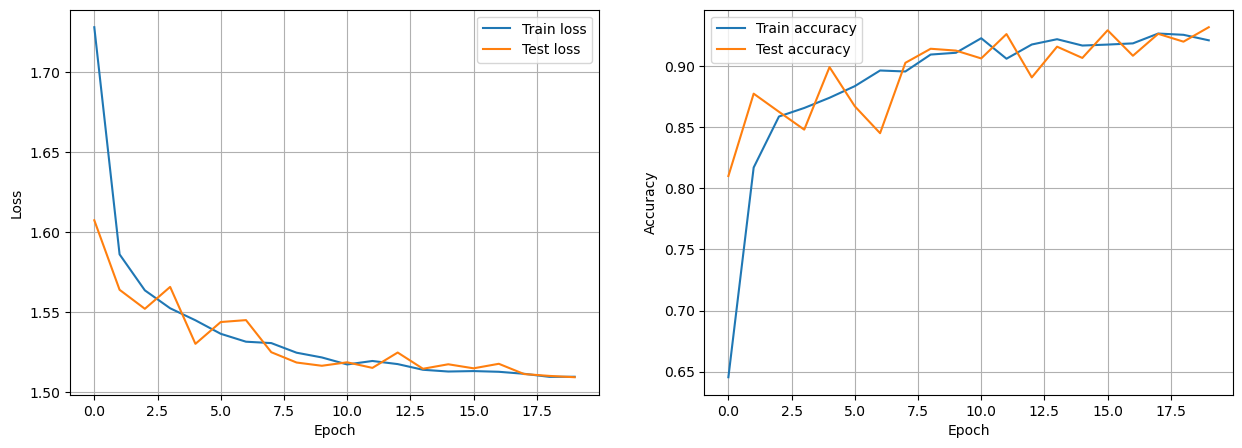

In [66]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(mean_train_loss_list,label="Train loss")
ax[0].plot(mean_test_loss_list,label="Test loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(train_acc_list,label="Train accuracy")
ax[1].plot(test_acc_list,label="Test accuracy")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()